In [ ]:
# Making the Pairwise Significance Heatmap
# Figure 10 (as of now) 

In [3]:
# Extinction ratio dictionary 

import pickle, os 
from pathlib import Path 

extinction_ratios_fname = Path(os.getcwd()) / "raw/ratios.dev" 
with open(extinction_ratios_fname, "rb") as f: 
    extinction_ratios = pickle.load(f) 

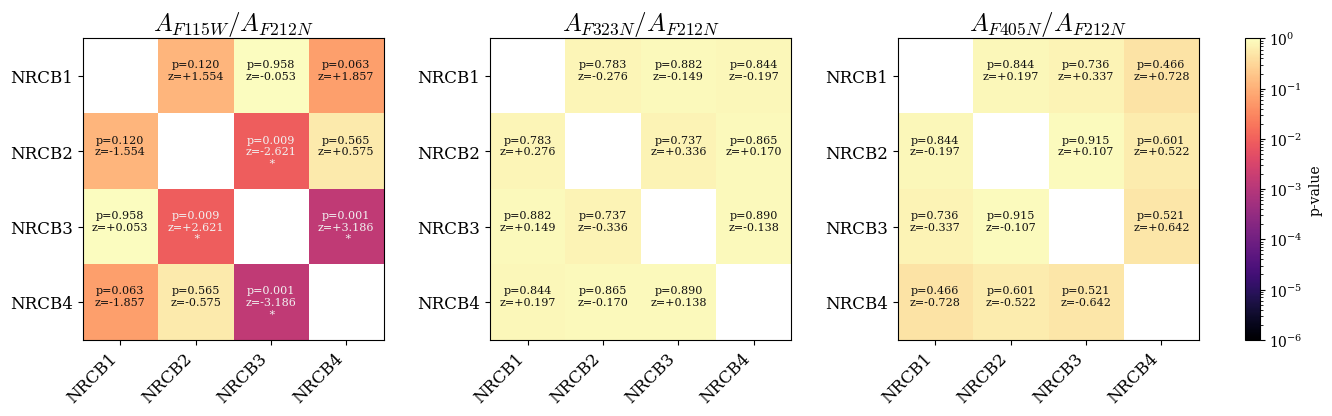

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm

plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

def plot_pairwise(ratio_dict: dict, alpha=0.05): 

    """ 
    Args: 
        * ratio_dict (dict): extinction_ratios dictionary 
        * alpha (float): significance level for asterisks
    """
    
    regions = list(ratio_dict.keys())
    ratios = list(next(iter(ratio_dict.values())).keys()) 

    n_reg = len(regions) 
    n_rat = len(ratios) 

    figure, axis = plt.subplots(
        1, n_rat, figsize=(4*n_rat + 1.5, 4), 
        constrained_layout=True
    ) 

    ratio_names = [ 
        r"$A_{F115W}/A_{F212N}$", 
        r"$A_{F323N}/A_{F212N}$",
        r"$A_{F405N}/A_{F212N}$", 
    ]

    idx = 0
    for ax, ratio in zip(np.ravel(axis), ratios): 
        mu   = np.array([ratio_dict[r][ratio][0] for r in regions])
        sigma = np.array([ratio_dict[r][ratio][1] for r in regions])

        z_score = (mu[:, None] - mu[None, :]) / np.sqrt(
            sigma[:, None] ** 2 + sigma[None, :] ** 2
        )
        p_score = 2.0 * norm.sf(np.abs(z_score))

        np.fill_diagonal(p_score, np.nan)
        np.fill_diagonal(z_score, np.nan)

        im = ax.imshow(
            p_score,
            norm=LogNorm(vmin=1e-6, vmax=1),
            cmap="magma",   # any perceptually‑uniform cmap works
        )

        # Annotate each cell
        for i in range(n_reg):
            for j in range(n_reg):
                if i == j:
                    continue
                p_val = p_score[i, j]
                z_val = z_score[i, j]
                star  = " *" if p_val < alpha else ""
                txt   = f"p={p_val:0.3f}\nz={z_val:+0.3f}\n{star}"
                ax.text(
                    j,
                    i,
                    txt,
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="#f2f2f2" if p_val < 0.01 else "#111111",
                )
        ax.set_xticks(range(n_reg), regions, rotation=45, ha="right", fontsize=12)
        ax.set_yticks(range(n_reg), regions, fontsize=12)
        ax.set_title(ratio_names[idx], fontsize=18)
        idx+=1

    cbar = figure.colorbar(im, ax=axis.ravel().tolist(), pad=0.04)
    cbar.set_label("p-value")
    plt.show()

plot_pairwise(extinction_ratios)